In [240]:
import datasets
import torch
from torch.utils.data import DataLoader
import transformers
from torchvision.transforms import v2

# For displaying:
import numpy as np
import matplotlib.pyplot as plt

In [241]:
mbatch_size = 2

In [242]:
# Device:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [263]:
# Load model:
tokenizer = transformers.AutoTokenizer.from_pretrained('aehrc/cxrmate-rrg24')
model = transformers.AutoModel.from_pretrained('aehrc/cxrmate-rrg24', trust_remote_code=True).to(device=device)
model.eval()

transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.Grayscale(num_output_channels=3),
        v2.Resize(size=model.config.encoder.image_size, antialias=True),
        v2.CenterCrop(size=[model.config.encoder.image_size]*2),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=model.config.encoder.image_mean, std=model.config.encoder.image_std),
    ]
)
        

/scratch3/nic261/environments/cxrmate2-virga-venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [272]:
# Data:
dataset = datasets.load_dataset('StanfordAIMI/interpret-cxr-test-public')['test']

def transform_batch(batch):
    batch['images'] = [torch.stack([transforms(j) for j in i]) for i in batch['images']]
    batch['images'] = torch.nn.utils.rnn.pad_sequence(batch['images'], batch_first=True, padding_value=0.0)  
    return batch

dataset = dataset.with_transform(transform_batch)
dataloader = DataLoader(dataset, batch_size=mbatch_size, shuffle=True)
batch = next(iter(dataloader))

'Study 1:'

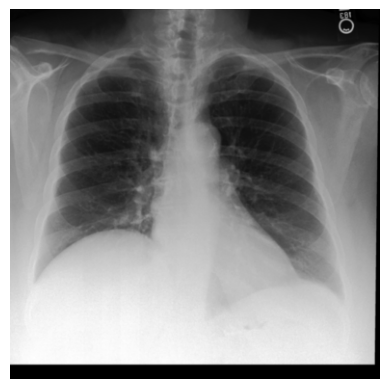

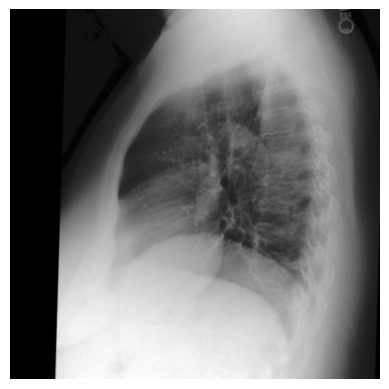

'Study 2:'

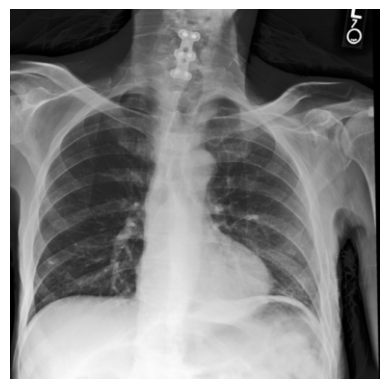

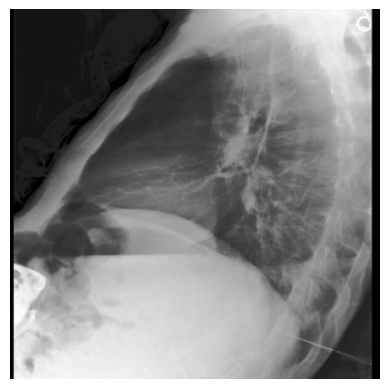

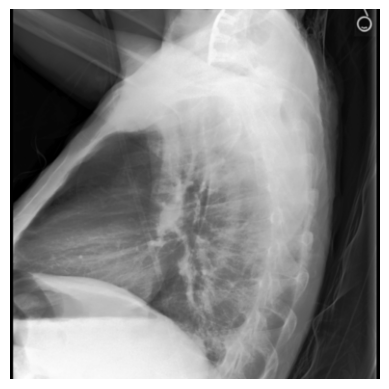

In [273]:
# Display images:
for i, j in enumerate(batch['images']):
    display(f'Study {i+1}:')
    for k in j:
        if not torch.all(k == 0):
            image = k.numpy()
            for channel in range(image.shape[0]):
                image[channel] -= image[channel].min()
                image[channel] /= image[channel].max()
            image = (image * 255).astype(np.uint8)
            plt.imshow(image.transpose(1, 2, 0), cmap='gray')
            plt.axis('off')
            plt.show()

In [280]:
# Generate findings only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    use_cache=True,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')]],
    eos_token_id=tokenizer.sep_token_id
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\n') for i in findings]

Findings:
	Left pneumothorax. slight mediastinal deviation to the right. left pleural effusion. pulmonary infiltrate in the left lower lobe.

Findings:
	No findings in the lung parenchyma or in the cardiomedastinal silhouette. no pleural effusion observed.



In [281]:
# Generate impression only:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    use_cache=True,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NI]')]],
    input_ids=torch.tensor([[tokenizer.bos_token_id, tokenizer.convert_tokens_to_ids('[NF]'), tokenizer.sep_token_id]]*mbatch_size, device=device, dtype=torch.long),
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Impression:\n\t{i}\n') for i in impression]

Impression:
	1. SINGLE FRONTAL VIEW OF THE CHEST DEMONSTRATES SLIGHT DECREASE IN THE LEFT-SIDED PNEUMOTHORAX, WHICH IS VERY SMALL. A SMALL AMOUNT OF SUBCUTANEOUS EMPHYSEMA IS SEEN ALONG THE LEFT LATERAL CHEST WALL. 2. PERSISTENT SMALL BILATERAL PLEURAL EFFUSIONS, LEFT GREATER THAN RIGHT. 3. STABLE LEFT MID LUNG ZONE OPACITY. 4. STABLE REDEMONSTRATION OF LEFT LATERAL RIB FRACTURES. LOW LUNG VOLUMES. 5. SMALL LEFT PLEURAL EFFUSION.

Impression:
	1. FRONTAL AND LATERAL VIEWS OF THE CHEST DEMONSTRATE PERSISTENT OPACIFICATION AT THE LEFT BASE WITH A SMALL ASSOCIATED PLEURAL EFFUSION. RIGHT LUNG IS OTHERWISE CLEAR. CARDIOMEDIASTINAL SILHOUETTE IS WITHIN NORMAL LIMITS. NO EVIDENCE OF DISPLACED RIB FRACTURES. 2. FOLLOW-UP FRONTAL AND LATERAL VIEWS OF THE CHEST DEMONSTRATE PERSISTENT LOW LUNG VOLUMES WITH INTERVAL IMPROVED AERATION OF THE LEFT LUNG. PERSISTENT SMALL LEFT PLEURAL EFFUSION.



In [291]:
# Generate both sections:
output_ids = model.generate(
    pixel_values=batch['images'].to(device=device),
    max_length=512,
    num_beams=4,
    use_cache=True,
    do_sample=True,
    temperature=1.2,
    bad_words_ids=[[tokenizer.convert_tokens_to_ids('[NF]')], [tokenizer.convert_tokens_to_ids('[NI]')]],
)
findings, impression = model.split_and_decode_sections(output_ids, tokenizer)
_ = [print(f'Findings:\n\t{i}\nImpression:\n\t{j}\n') for i,j in zip(findings, impression)]

Findings:
	Judgment judgment follow-up of pneumonia sars cov 2. imaging technique radiological findings are compared with x-ray from 04 0 20. cardiomedastinal silhouette and pulmonary hila of normal morphology and size. no foci of alveolar consolidation are observed. there is no pleural effusion. no significant changes compared to previous study of date date date date date with no changes in the left hemithorax, visualizing left basal atelectasis and loculated left pleural effusion. no alveolar consolidations are observed, nor is there observed in this hemithorax. cardiomedastinal silhouette and pulmonary hila of normal morphology and size. no alterations in the thoracic cage. no pleural effusion. no other alterations. no significant alterations in the bone structures included in the study. conclusion: study without changes compared to the previous study conducted 2 days ago. persistent left pleural effusion and left basal atelectasis remain unchanged. signs of pulmonary hyperinflation